In [1]:
# https://tensorflow.google.cn/tutorials/text/transformer

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.6.4
sys.version_info(major=3, minor=7, micro=12, releaselevel='final', serial=0)
matplotlib 3.5.2
numpy 1.21.6
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.6.4
keras.api._v2.keras 2.6.0


In [3]:
!nvidia-smi

Tue Aug 23 11:44:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# 1. loads data
# 2. preprocesses data -> dataset
# 3. tools
# 3.1 generates position embedding
# 3.2 create mask. (a. padding, b. decoder)
# 3.3 scaled_dot_product_attention
# 4. builds model 分为以下6步
# 4.1 MultiheadAttention
# 4.2 EncoderLayer
# 4.3 DecoderLayer
# 4.4 EncoderModel
# 4.5 DecoderModel
# 4.6 Transformer
# 5. optimizer & loss
# 6. train step -> train
# 7. Evaluate and Visualize

In [5]:
import tensorflow_datasets as tfds

# 基于subword的葡萄牙语到英语的文本对应
# as_supervised获取 (features, label) 元组作为替代的监督数据集
examples, info = tfds.load('ted_hrlr_translate/pt_to_en',
                           with_info=True,
                           as_supervised=True)
print(type(examples))  # <class 'dict'>
train_examples, validation_examples = examples['train'], examples['validation']
print(type(train_examples))  # <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
print(type(train_examples.take(1)))  # <class 'tensorflow.python.data.ops.dataset_ops.TakeDataset'>
print('-' * 50)
# 数据集的信息描述
print(info)

2022-08-23 11:44:45.054484: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


<class 'dict'>
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TakeDataset'>
--------------------------------------------------
tfds.core.DatasetInfo(
    name='ted_hrlr_translate',
    full_name='ted_hrlr_translate/pt_to_en/1.0.0',
    description="""
    Data sets derived from TED talk transcripts for comparing similar language pairs
    where one is high resource and the other is low resource.
    """,
    config_description="""
    Translation dataset from pt to en in plain text.
    """,
    homepage='https://github.com/neulab/word-embeddings-for-nmt',
    data_path='/root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0',
    download_size=124.94 MiB,
    dataset_size=10.89 MiB,
    features=Translation({
        'en': Text(shape=(), dtype=tf.string),
        'pt': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=('pt', 'en'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_e

2022-08-23 11:44:45.071965: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-23 11:44:45.076406: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-23 11:44:45.081773: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-23 11:44:45.082226: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [6]:
# 葡萄牙语中有一些特除的字符，用转义字符来打印
for pt, en in train_examples.take(5):
    print(pt.numpy())
    print(en)
    print()
print(train_examples)

b'e quando melhoramos a procura , tiramos a \xc3\xbanica vantagem da impress\xc3\xa3o , que \xc3\xa9 a serendipidade .'
tf.Tensor(b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .', shape=(), dtype=string)

b'mas e se estes fatores fossem ativos ?'
tf.Tensor(b'but what if it were active ?', shape=(), dtype=string)

b'mas eles n\xc3\xa3o tinham a curiosidade de me testar .'
tf.Tensor(b"but they did n't test for curiosity .", shape=(), dtype=string)

b'e esta rebeldia consciente \xc3\xa9 a raz\xc3\xa3o pela qual eu , como agn\xc3\xb3stica , posso ainda ter f\xc3\xa9 .'
tf.Tensor(b'and this conscious defiance is why i , as an agnostic , can still have faith .', shape=(), dtype=string)

b"`` `` '' podem usar tudo sobre a mesa no meu corpo . ''"
tf.Tensor(b'you can use everything on the table on me .', shape=(), dtype=string)

<PrefetchDataset shapes: ((), ()), types: (tf.string, tf.string)>


2022-08-23 11:44:46.796362: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-08-23 11:44:46.836658: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [7]:
# 分词加索引变为subword数据集  将语料库中文本分成target_vocab_size左右个subword
en_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2 ** 13)
pt_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2 ** 13)
print(en_tokenizer.vocab_size)
print(pt_tokenizer.vocab_size)
print(type(en.numpy() for pt, en in train_examples))  # <class 'generator'>

8087
8214
<class 'generator'>


In [8]:
# 测试
sample_string = "Transformer is awesome."
tokenized_string = en_tokenizer.encode(sample_string)
print('Tokenized string is {}'.format(tokenized_string))
origin_string = en_tokenizer.decode(tokenized_string)
print(f'The original string is {origin_string}')
assert origin_string == sample_string
for token in tokenized_string:
    print('{} --> "{}"-->{}'.format(token, en_tokenizer.decode([token]), len(en_tokenizer.decode([token]))))

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string is Transformer is awesome.
7915 --> "T"-->1
1248 --> "ran"-->3
7946 --> "s"-->1
7194 --> "former "-->7
13 --> "is "-->3
2799 --> "awesome"-->7
7877 --> "."-->1


In [9]:
buffer_size = 20000
batch_size = 64
max_length = 40  # 输入和输出的最大长度是40


# # tokenizer(分词器)编码索引0~tokenizer.vocab_size-1  开始标记tokenizer.vocab_size 结束标记tokenizer.vocab_size+1
def encode_to_subword(pt_sentence, en_sentence):
    pt_sequence = [pt_tokenizer.vocab_size]\
                  + pt_tokenizer.encode(pt_sentence.numpy())\
                  + [pt_tokenizer.vocab_size + 1]
    en_sequence = [en_tokenizer.vocab_size]\
                  + en_tokenizer.encode(en_sentence.numpy())\
                  + [en_tokenizer.vocab_size + 1]
    return pt_sequence, en_sequence


# 为了使本示例较小且相对较快，删除长度大于40个标记的样本
def filter_by_max_length(pt, en):
    return tf.logical_and(tf.size(pt) <= max_length, tf.size(en) <= max_length)


# 用py_function封装一下encode_to_subword
def tf_encode_to_subword(pt_sentence, en_sentence):
    return tf.py_function(encode_to_subword,  # python函数
                          [pt_sentence, en_sentence],  # 函数输入参数
                          [tf.int64, tf.int64])  # 函数返回值类型


# map内部的操作以图模式（graph mode）运行，map接收一个不具有numpy属性的图张量（graph tensor）
train_dataset = train_examples.map(tf_encode_to_subword)
train_dataset = train_dataset.filter(filter_by_max_length)
# 洗牌并将每一批所有样本都填充到当前批样本中的最大长度
train_dataset = train_dataset.shuffle(buffer_size).padded_batch(
    batch_size, padded_shapes=([-1], [-1]))
validation_dataset = validation_examples.map(tf_encode_to_subword)
validation_dataset = validation_dataset.filter(filter_by_max_length).padded_batch(
    batch_size, padded_shapes=([-1], [-1]))

In [10]:
x = tf.constant([1, 2, 3, 4])
y = tf.constant([1, 2, 3, 4])
print(tf.size(tf.constant([[[1, 2, 3, 4, 5],[1, 2, 3, 4, 5]],[[1, 2, 3, 4, 5],[1, 2, 3, 4, 5]]])))
print(tf.math.logical_and(tf.size(x) <= 4, tf.size(y) <= 4))

tf.Tensor(20, shape=(), dtype=int32)
tf.Tensor(True, shape=(), dtype=bool)


In [11]:
for pt_batch, en_batch in train_dataset.take(1):
    print(pt_batch.shape, pt_batch[0])
    print(en_batch.shape, en_batch[0])

2022-08-23 11:48:20.097177: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 5803 of 20000
2022-08-23 11:48:30.098974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 11635 of 20000
2022-08-23 11:48:40.097427: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 17559 of 20000


(64, 37) tf.Tensor(
[8214  186 3943    1   33 5862  314    1    8 2637    2 8215    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0], shape=(37,), dtype=int64)
(64, 37) tf.Tensor(
[8087  230 2918    1   68 6557 1518    1   13 7679  994 7928    2 8088
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0], shape=(37,), dtype=int64)


2022-08-23 11:48:44.382811: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


In [12]:
print(np.arange(512)[np.newaxis, :].shape)
print(2 * (np.arange(512)[np.newaxis, :] // 2))

(1, 512)
[[  0   0   2   2   4   4   6   6   8   8  10  10  12  12  14  14  16  16
   18  18  20  20  22  22  24  24  26  26  28  28  30  30  32  32  34  34
   36  36  38  38  40  40  42  42  44  44  46  46  48  48  50  50  52  52
   54  54  56  56  58  58  60  60  62  62  64  64  66  66  68  68  70  70
   72  72  74  74  76  76  78  78  80  80  82  82  84  84  86  86  88  88
   90  90  92  92  94  94  96  96  98  98 100 100 102 102 104 104 106 106
  108 108 110 110 112 112 114 114 116 116 118 118 120 120 122 122 124 124
  126 126 128 128 130 130 132 132 134 134 136 136 138 138 140 140 142 142
  144 144 146 146 148 148 150 150 152 152 154 154 156 156 158 158 160 160
  162 162 164 164 166 166 168 168 170 170 172 172 174 174 176 176 178 178
  180 180 182 182 184 184 186 186 188 188 190 190 192 192 194 194 196 196
  198 198 200 200 202 202 204 204 206 206 208 208 210 210 212 212 214 214
  216 216 218 218 220 220 222 222 224 224 226 226 228 228 230 230 232 232
  234 234 236 236 238 238 240

位置编码

(1, 50, 512)


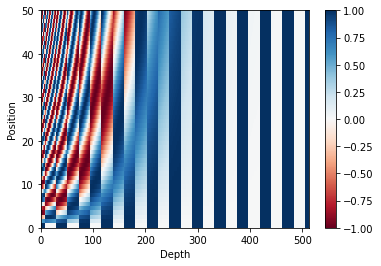

In [13]:
# PE(pos, 2i)   = sin(pos / 10000^(2i/d_model))
# PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
def get_angles(position, i, d_model):
    # pos.shape: [sentence_length, 1]
    # i.shape : [1, d_model]
    # result.shape: [sentence_length, d_model]
    angle_rates = 1 / np.power(10000, (2 * (i // 2) / np.float32(d_model)))
    return position * angle_rates


# 计算位置信息 让不同位置有区分度 和词没关系
def get_position_embedding(sentence_length, d_model):
    # sentence_length和d_model都扩展为矩阵
    # position是sentense中词的位置(0->sentence_length-1)，i是从0到511(dim的变化范围)
    angle_rads = get_angles(np.arange(sentence_length)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, ...],  # ...和:作用形同 (1,512)
                            d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    # [sentence_length, d_model]-->[1, sentence_length, d_model]
    position_embedding = angle_rads[np.newaxis, :]
    return tf.cast(position_embedding, dtype=tf.float32)


# 测试
position_embedding = get_position_embedding(50, 512)
print(position_embedding.shape)


def plot_position_embedding(position_embedding):
    plt.pcolormesh(position_embedding[0], cmap='RdBu')
    plt.xlabel('Depth')
    plt.xlim((0, 512))
    plt.ylabel('Position')
    plt.colorbar()
    plt.show()


plot_position_embedding(position_embedding)

In [14]:
# 生成mask  padding_mask  look_ahead
# batch_data.shape: [batch_size, seq_len]
# mask会乘以一个接近负无穷的数，从而在计算softmax时一个非常小的数的指数概率接近为0
def create_padding_mask(batch_data):
    # 原数据变为0，填充部分变为1
    padding_mask = tf.cast(tf.math.equal(batch_data, 0), tf.float32)
    # [batch_size, 1, 1, seq_len]
    return padding_mask[:, tf.newaxis, tf.newaxis, :]


# 测试
test_x = tf.constant([[7, 6, 0, 0, 0], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
print(create_padding_mask(test_x))

tf.Tensor(
[[[[0. 0. 1. 1. 1.]]]


 [[[0. 0. 0. 1. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(3, 1, 1, 5), dtype=float32)


In [15]:
# 前瞻遮挡（look-ahead mask）用于遮挡一个序列中的后续标记（future tokens）
# 训练时Decode要和预测时情况保持相同 当前en词只能注意到自己及前面的词
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)


# 测试
print(create_look_ahead_mask(4))

tf.Tensor(
[[0. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]], shape=(4, 4), dtype=float32)


In [16]:
# tf.linalg.band_part(input, 0, -1) ==> Upper triangular part.
# tf.linalg.band_part(input, -1, 0) ==> Lower triangular part.
# tf.linalg.band_part(input, 0, 0) ==> Diagonal.
print(tf.linalg.band_part(tf.ones((5, 5)), 0, 0))
print(tf.linalg.band_part(tf.ones((5, 5)), 0, -1))

tf.Tensor(
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]], shape=(5, 5), dtype=float32)
tf.Tensor(
[[1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1.]], shape=(5, 5), dtype=float32)


缩放点积注意力(自注意力)

In [17]:
# Q（请求（query））、K（主键（key））、V（数值（value））
# 便于理解 可以认为q、k、v都还是原来的输入(密集向量)
def scaled_dot_product_attention(q, k, v, mask):
    """
    Args:
    多头注意力中deepth = d_model // num_heads)
    - q: shape == (..., seq_len_q, depth)
    - k: shape == (..., seq_len_k, depth)
    - v: shape == (..., seq_len_v, depth_v)
    - k,v必须有匹配的倒数第二个维度 seq_len_k == seq_len_v
    - mask: shape == (..., seq_len_q, seq_len_k)  Float张量
    Returns:
    - output: weighted sum
    - attention_weights: weights of attention
    """
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    # 点积注意力被缩小了深度的平方根倍  (..., seq_len_q, seq_len_k)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    # 将 mask 加入到缩放的张量上
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    # softmax 在最后一个轴（seq_len_k）上归一化，因此分数相加等于1。
    # attention_weights.shape: (..., seq_len_q, seq_len_k)
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    # output.shape: (..., seq_len_q, depth_v)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

In [18]:
# 测试
def print_scaled_dot_product_attention(q, k, v):
    temp_output, temp_attention = scaled_dot_product_attention(q, k, v, None)
    print("Attention weights are:")
    print(temp_attention)
    print("Output is:")
    print(temp_output)

In [19]:
np.set_printoptions(suppress=True)
temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)
# temp_attention @ temp_v = temp_output
temp_q1 = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_scaled_dot_product_attention(temp_q1, temp_k, temp_v)
print('-' * 50)
temp_q2 = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_scaled_dot_product_attention(temp_q2, temp_k, temp_v)
print('-' * 50)
temp_q3 = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_scaled_dot_product_attention(temp_q3, temp_k, temp_v)
print('-' * 50, '\n', '-' * 50)
temp_q4 = tf.constant([[0, 10, 0],
                       [0, 0, 10],
                       [10, 10, 0],
                       [10, 0, 10]], dtype=tf.float32)  # (3, 3)
print_scaled_dot_product_attention(temp_q4, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)
--------------------------------------------------
Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)
--------------------------------------------------
Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)
-------------------------------------------------- 
 --------------------------------------------------
Attention weights are:
tf.Tensor(
[[0.         1.         0.         0.        ]
 [0.         0.         0.5        0.5       ]
 [0.5        0.5        0.         0.        ]
 [0.33333334 0.         0.33333334 0.33333334]], shape=(4, 4), dtype=float32)
Output is:
tf.Tensor(
[[ 10.          0.       ]
 [550.          5.5      ]
 [  5.5         0.       ]


多头注意力

In [20]:
class MultiHeadAttention(keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert self.d_model % self.num_heads == 0
        self.depth = self.d_model // self.num_heads

        self.WQ = keras.layers.Dense(self.d_model)
        self.WK = keras.layers.Dense(self.d_model)
        self.WV = keras.layers.Dense(self.d_model)

        self.dense = keras.layers.Dense(self.d_model)

    def split_heads(self, x, batch_size):
        # x.shape: (batch_size, seq_len, d_model)
        # d_model = num_heads * depth
        # x -> (batch_size, num_heads, seq_len, depth)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, q, k, v, mask):
        batch_size = tf.shape(q)[0]
        # q.shape: (batch_size, seq_len_q, d_model)
        q = self.WQ(q)
        # k.shape: (batch_size, seq_len_k, d_model)
        k = self.WQ(k)
        # v.shape: (batch_size, seq_len_v, d_model)
        v = self.WQ(v)
        # q.shape: (batch_size, num_heads, seq_len_q, depth)
        q = self.split_heads(q, batch_size)
        # k.shape: (batch_size, num_heads, seq_len_k, depth)
        k = self.split_heads(k, batch_size)
        # v.shape: (batch_size, num_heads, seq_len_v, depth)
        v = self.split_heads(v, batch_size)
        # scaled_attention_outputs.shape: (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape: (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention_outputs, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        # scaled_attention_outputs.shape: (batch_size, seq_len_q, num_heads, depth)
        scaled_attention_outputs = tf.transpose(
            scaled_attention_outputs, perm=[0, 2, 1, 3])
        # concat_attention.shape: (batch_size, seq_len_q, d_model)
        concat_attention = tf.reshape(scaled_attention_outputs, (batch_size, -1, self.d_model))
        # output.shape: (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)
        return output, attention_weights


# 测试
test_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 40, 256))  # (batch_size, encoder_sequence_length, d_model)
test_output, test_attention = test_mha(y, y, y, mask=None)
print(test_output.shape)  # 输出的形状，和x的形状一致
print(test_attention.shape)  # 注意力的形状

(1, 40, 512)
(1, 8, 40, 40)


In [21]:
# 点式前馈网络（Point wise feed forward network）
def feed_forward_network(d_model, dff):
    # dff: dim of feed forward network.
    return keras.Sequential([
        keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])


# 测试
sample_ffn = feed_forward_network(512, 2048)
print(sample_ffn(tf.random.uniform((64, 50, 512))).shape)

(64, 50, 512)


Encoder层

In [22]:
class EncoderLayer(keras.layers.Layer):
    """
    x -> self attention -> add & normalize & dropout
      -> feed_forward -> add & normalize & dropout
    """

    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = feed_forward_network(d_model, dff)

        # 分母将方差加上epsilon以避免除零问题
        self.layer_norm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = keras.layers.LayerNormalization(epsilon=1e-6)

        # rate丢失比例
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, x, training, encoder_padding_mask):
        # x.shape: (batch_size, seq_len, dim=d_model)
        # attn_output.shape: (batch_size, seq_len, d_model)
        attention_output, _ = self.mha(x, x, x, encoder_padding_mask)
        # training参数用来指示当前阶段是出于训练阶段还是测试阶段
        # 如果training为true（即训练阶段），则会进行dropout，否则不进行dropout，直接返回inputs
        attention_output = self.dropout1(attention_output, training=training)
        # out1.shape: (batch_size, seq_len, d_model)
        out1 = self.layer_norm1(x + attention_output)
        # ffn_output.shape: (batch_size, seq_len, d_model)
        ffn_output = self.ffn(out1)
        # out2.shape      : (batch_size, seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layer_norm2(out1 + ffn_output)
        return out2


# 测试
sample_encoder_layer = EncoderLayer(512, 8, 2048)
sample_input = tf.random.uniform((64, 50, 512))
sample_output = sample_encoder_layer(sample_input, False, None)
print(sample_output.shape)
print('-' * 50)
print(sample_encoder_layer.variables)

(64, 50, 512)
--------------------------------------------------
[<tf.Variable 'encoder_layer/multi_head_attention_1/dense_6/kernel:0' shape=(512, 512) dtype=float32, numpy=
array([[-0.04558273, -0.04869477,  0.07611049, ..., -0.02285348,
        -0.01056693,  0.00351435],
       [ 0.02097565,  0.02470371, -0.06166561, ...,  0.0144144 ,
         0.06585964,  0.02990427],
       [-0.04302579,  0.06043071,  0.05400682, ...,  0.04662977,
        -0.05362362,  0.02249705],
       ...,
       [-0.01778095,  0.01420367, -0.00185507, ..., -0.035521  ,
        -0.05676414,  0.06631922],
       [ 0.06472831, -0.01528639,  0.05155804, ..., -0.0694083 ,
         0.0282392 ,  0.02126522],
       [-0.02114797, -0.03655751,  0.0668219 , ..., -0.00672907,
        -0.04601396,  0.06300788]], dtype=float32)>, <tf.Variable 'encoder_layer/multi_head_attention_1/dense_6/bias:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 

In [23]:
print(sample_encoder_layer.trainable_variables)

[<tf.Variable 'encoder_layer/multi_head_attention_1/dense_6/kernel:0' shape=(512, 512) dtype=float32, numpy=
array([[-0.04558273, -0.04869477,  0.07611049, ..., -0.02285348,
        -0.01056693,  0.00351435],
       [ 0.02097565,  0.02470371, -0.06166561, ...,  0.0144144 ,
         0.06585964,  0.02990427],
       [-0.04302579,  0.06043071,  0.05400682, ...,  0.04662977,
        -0.05362362,  0.02249705],
       ...,
       [-0.01778095,  0.01420367, -0.00185507, ..., -0.035521  ,
        -0.05676414,  0.06631922],
       [ 0.06472831, -0.01528639,  0.05155804, ..., -0.0694083 ,
         0.0282392 ,  0.02126522],
       [-0.02114797, -0.03655751,  0.0668219 , ..., -0.00672907,
        -0.04601396,  0.06300788]], dtype=float32)>, <tf.Variable 'encoder_layer/multi_head_attention_1/dense_6/bias:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.

Decoder层

In [24]:
class DecoderLayer(keras.layers.Layer):
    """
    x -> self attention -> add & normalize & dropout -> out1
    out1 , encoding_outputs -> attention -> add & normalize & dropout -> out2
    out2 -> ffn -> add & normalize & dropout -> out3
    """

    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        self.ffn = feed_forward_network(d_model, dff)

        self.layer_norm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm3 = keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
        self.dropout3 = keras.layers.Dropout(rate)

    def call(self, x, encoding_outputs, training, decoder_mask, encoder_decoder_padding_mask):
        # x.shape: (batch_size, target_seq_len, d_model)
        # encoding_outputs.shape: (batch_size, input_seq_len, d_model)
        # decoder_mask:由look_ahead_mask和decoder_padding_mask合并而来

        # attention1.shape: (batch_size, target_seq_len, d_model)
        attention1, attention_weights1 = self.mha1(x, x, x, decoder_mask)
        attention1 = self.dropout1(attention1, training=training)
        # out1.shape: (batch_size, target_seq_len, d_model)
        out1 = self.layer_norm1(attention1 + x)

        # attention2.shape: (batch_size, target_seq_len, d_model)
        attention2, attention_weights2 = self.mha2(
            out1, encoding_outputs, encoding_outputs,
            encoder_decoder_padding_mask)
        attention2 = self.dropout2(attention2, training=training)
        # out2.shape: (batch_size, target_seq_len, d_model)
        out2 = self.layer_norm2(attention2 + out1)

        # ffn_output.shape: (batch_size, target_seq_len, d_model)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        # out3.shape: (batch_size, target_seq_len, d_model)
        out3 = self.layer_norm3(ffn_output + out2)
        return out3, attention_weights1, attention_weights2


# 测试
sample_decoder_layer = DecoderLayer(512, 8, 2048)
sample_decoder_input = tf.random.uniform((64, 60, 512))
sample_decoder_output, sample_decoder_attention_weights1, sample_decoder_attention_weights2\
    = sample_decoder_layer(sample_decoder_input, sample_output, False, None, None)
print(sample_decoder_output.shape)  # (batch_size, target_seq_len, d_model)
print(sample_decoder_attention_weights1.shape)  # (60, 512) @ (512, 60) = (60, 60)
# q(64, 60, 512) @ k(64, 512, 50) = attn(64, 60, 50)-> @ v(64, 50, 512) = output(64, 60, 512)
print(sample_decoder_attention_weights2.shape)  # (60, 512) @ (512, 50) = (60, 50)

(64, 60, 512)
(64, 8, 60, 60)
(64, 8, 60, 50)


EncoderModel

In [25]:
class EncoderModel(keras.layers.Layer):
    def __init__(self, num_lauers, input_vocab_size, input_max_length,
                 d_model, num_heads, dff, rate=0.1):
        super(EncoderModel, self).__init__()
        self.d_model = d_model
        self.num_layers = num_lauers
        self.max_length = input_max_length
        # 构建embedding层
        self.embedding = keras.layers.Embedding(input_vocab_size, self.d_model)
        # position_embedding.shape: (1, max_length, d_model)
        self.position_embedding = get_position_embedding(input_max_length, self.d_model)
        self.dropout = keras.layers.Dropout(rate)
        self.encoder_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                               for _ in range(self.num_layers)]

    def call(self, x, training, encoder_padding_mask):
        # x.shape: (batch_size, input_seq_len)
        input_seq_len = tf.shape(x)[1]
        tf.debugging.assert_less_equal(input_seq_len, self.max_length,
                                       'input_seq_len should be less or equal to self.max_length')
        # x.shape: (batch_size, input_seq_len, d_model)
        x = self.embedding(x)
        # 缩放-->缩
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # 将嵌入和位置编码相加 x长度比position_embedding可能要小
        # position_embedding的轴0的size是1，会在x的轴零维度进行广播相加
        x += self.position_embedding[:, :input_seq_len, :]
        x = self.dropout(x, training=training)

        # 上层输出作为下层输入
        for i in range(self.num_layers):
            x = self.encoder_layers[i](x, training, encoder_padding_mask)
        # x.shape: (batch_size, input_seq_len, d_model)
        return x


# 测试
sample_encoder_model = EncoderModel(2, 8500, max_length, 512, 8, 2048)
sample_encoder_model_input = tf.random.uniform((64, 37))
sample_encoder_model_output = sample_encoder_model(
    sample_encoder_model_input, False, encoder_padding_mask=None)
print(sample_encoder_model_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 37, 512)


DecoderModel

In [26]:
class DecoderModel(keras.layers.Layer):
    def __init__(self, num_layers, target_vocab_size, target_input_max_length,
                 d_model, num_heads, dff, rate=0.1):
        super(DecoderModel, self).__init__()
        self.num_layers = num_layers
        self.max_length = target_input_max_length
        self.d_model = d_model
        self.embedding = keras.layers.Embedding(target_vocab_size, d_model)
        self.position_embedding = get_position_embedding(target_input_max_length, d_model)
        self.dropout = keras.layers.Dropout(rate)
        self.decoder_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                               for _ in range(self.num_layers)]

    def call(self, x, encoding_outputs, training, decoder_mask, encoder_decoder_padding_mask):
        # x.shape: (batch_size, output_seq_len)
        output_seq_len = tf.shape(x)[1]
        tf.debugging.assert_less_equal(output_seq_len, self.max_length,  # 位置编码长度
                                       "output_seq_len should be less or equal to self.max_length")
        attention_weights = {}
        # x.shape: (batch_size, output_seq_len, d_model)
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.position_embedding[:, :output_seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x, attention1, attention2 = self.decoder_layers[i](
                x, encoding_outputs, training, decoder_mask, encoder_decoder_padding_mask)
            attention_weights[f'decoder_layer{i + 1}_attention1'] = attention1
            attention_weights[f'decoder_layer{i + 1}_attention2'] = attention2
        # x.shape: (batch_size, output_seq_len, d_model)
        return x, attention_weights


# 测试
sample_decoder_model = DecoderModel(2, 8000, max_length, 512, 8, 2048)
sample_decoder_model_input = tf.random.uniform((64, 35))
sample_decoder_model_output, sample_decoder_model_attentions\
    = sample_decoder_model(sample_decoder_model_input, sample_encoder_model_output,
                           training=False, decoder_mask=None, encoder_decoder_padding_mask=None)
print(sample_decoder_model_output.shape)
print('-' * 50)
for key in sample_decoder_model_attentions:
    print(key, sample_decoder_model_attentions[key].shape)

(64, 35, 512)
--------------------------------------------------
decoder_layer1_attention1 (64, 8, 35, 35)
decoder_layer1_attention2 (64, 8, 35, 37)
decoder_layer2_attention1 (64, 8, 35, 35)
decoder_layer2_attention2 (64, 8, 35, 37)


Transformer

In [27]:
class Transformer(keras.Model):
    def __init__(self, num_layers, input_vocab_size, target_vocab_size,
                 max_length, d_model, num_heads, dff, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder_model = EncoderModel(num_layers, input_vocab_size,
                                          max_length, d_model, num_heads, dff, rate)
        self.decoder_model = DecoderModel(num_layers, target_vocab_size,
                                          max_length, d_model, num_heads, dff, rate)
        self.final_layer = keras.layers.Dense(target_vocab_size)

    def call(self, input, target, training, encoder_padding_mask,
             decoder_mask, encoder_decoder_padding_mask):
        # encoding_outputs.shape: (batch_size, input_seq_len, d_model)
        encoding_outputs = self.encoder_model(input, training, encoder_padding_mask)
        # decoding_outputs.shape: (batch_size, output\target_seq_len, d_model)

        decoding_outputs, attention_weights = self.decoder_model(
            target, encoding_outputs, training, decoder_mask, encoder_decoder_padding_mask)

        # predictions.shape: (batch_size, output_seq_len, target_vocab_size)
        predictions = self.final_layer(decoding_outputs)
        return predictions, attention_weights


# 测试
sample_transformer = Transformer(4, pt_tokenizer.vocab_size + 2, en_tokenizer.vocab_size + 2,
                                 max_length, 128, 8, 512, rate = 0.1)
temp_input = tf.random.uniform((64, 26))
temp_target = tf.random.uniform((64, 31))
temp_predictions, temp_attention_weights = sample_transformer(temp_input, temp_target,
                                                              training=False, encoder_padding_mask=None,
                                                              decoder_mask=None,
                                                              encoder_decoder_padding_mask=None)
print(temp_predictions.shape)
print('-' * 50)
for key in temp_attention_weights:
    print(key, temp_attention_weights[key].shape)
print('-' * 50)
print(sample_transformer.summary())

(64, 31, 8089)
--------------------------------------------------
decoder_layer1_attention1 (64, 8, 31, 31)
decoder_layer1_attention2 (64, 8, 31, 26)
decoder_layer2_attention1 (64, 8, 31, 31)
decoder_layer2_attention2 (64, 8, 31, 26)
decoder_layer3_attention1 (64, 8, 31, 31)
decoder_layer3_attention2 (64, 8, 31, 26)
decoder_layer4_attention1 (64, 8, 31, 31)
decoder_layer4_attention2 (64, 8, 31, 26)
--------------------------------------------------
Model: "transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_model_1 (EncoderMode multiple                  1712640   
_________________________________________________________________
decoder_model_1 (DecoderMode multiple                  1829504   
_________________________________________________________________
dense_118 (Dense)            multiple                  1043481   
Total params: 4,585,625
Trainable params: 4,585,625
Non-trainabl

In [28]:
# 1. initializes model.
# 2. define loss, optimizer, learning_rate schedule
# 3. train_step
# 4. train process

In [29]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
input_vocab_size = pt_tokenizer.vocab_size + 2
target_vocab_size = en_tokenizer.vocab_size + 2
dropout_rate = 0.1
transformer = Transformer(num_layers, input_vocab_size, target_vocab_size,
                          max_length, d_model, num_heads, dff, dropout_rate)

优化器

In [30]:
# 根据论文中的公式，将Adam优化器与自定义的学习速率调度程序（scheduler）配合使用
# lrate = (d_model ** -0.5) * min(step_num ** (-0.5),
#                                 step_num * warm_up_steps **(-1.5))
class CustomizedSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_modedl, warmup_steps=4000):
        super(CustomizedSchedule, self).__init__()
        self.d_model = tf.cast(d_modedl, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        arg3 = tf.math.rsqrt(self.d_model)
        return arg3 * tf.math.minimum(arg1, arg2)


learning_rate = CustomizedSchedule(d_model)
optimizer = keras.optimizers.Adam(learning_rate, beta_1=0.9,
                                  beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train step')

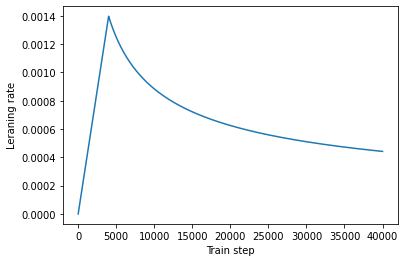

In [31]:
# 学习率变化图
temp_learning_rate_schedule = CustomizedSchedule(d_model)
plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Leraning rate")
plt.xlabel("Train step")

损失函数与指标（Loss and metrics）

In [32]:
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True)


def loss_function(real, pred):
    # padding部分不计算损失
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

初始化mask矩阵 训练时直接输入

In [33]:
def create_masks(input, target):
    encoder_padding_mask = create_padding_mask(input)
    # 在解码器的第二个注意力模块使用 该填充遮挡用于遮挡编码器的输出
    # decoder不应该到encoder的padding上去花费精力
    encoder_decoder_padding_mask = create_padding_mask(input)
    # 在解码器的第一个注意力模块使用 用于填充(pad)和遮挡(mask)解码器获取到的输入的后续标记(future tokens)
    # 像encoder一样忽略掉padding部分，像预测时一样看不到后面的词(后面的词还没预测出来)
    look_ahead_mask = create_look_ahead_mask(tf.shape(target)[1])
    decoder_padding_mask = create_padding_mask(target)
    decoder_mask = tf.maximum(decoder_padding_mask, look_ahead_mask)
    return encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask

In [34]:
checkpoint_dir = './Transformer_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=transformer)
if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)
# 如果检查点存在，则恢复最新的检查点
if tf.train.latest_checkpoint(checkpoint_dir):
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
    print('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [35]:
train_loss = keras.metrics.Mean(name='train_loss')
train_accuracy = keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')


@tf.function(experimental_relax_shapes=True)
def train_step(input, target):
    target_inp = target[:, :-1]
    target_real = target[:, 1:]
    encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask\
        = create_masks(input, target_inp)
    with tf.GradientTape() as tape:
        predictions, _ = transformer(input, target_inp, True, encoder_padding_mask,
                                     decoder_mask, encoder_decoder_padding_mask)
        loss = loss_function(target_real, predictions)
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    train_loss(loss)
    train_accuracy(target_real, predictions)


epochs = 30
for epoch in range(epochs):
    start = time.time()
    # 清空累计 重新计算
    train_loss.reset_states()
    train_accuracy.reset_states()
    # input -> portuguese, target -> english
    for batch, (input, target) in enumerate(train_dataset):
        train_step(input, target)
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
                epoch + 1, batch, train_loss.result(),
                train_accuracy.result()))
    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(
        epoch + 1, train_loss.result(), train_accuracy.result()))
    print('Time take for 1 epoch: {} secs\n'.format(
        time.time() - start))
    checkpoint.save(file_prefix=checkpoint_prefix)

2022-08-23 11:48:57.266338: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 6080 of 20000
2022-08-23 11:49:07.265446: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12157 of 20000
2022-08-23 11:49:17.265518: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 18209 of 20000
2022-08-23 11:49:20.080009: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


Epoch 1 Batch 0 Loss 0.8928 Accuracy 0.6939
Epoch 1 Batch 100 Loss 1.0357 Accuracy 0.6709
Epoch 1 Batch 200 Loss 1.0297 Accuracy 0.6725
Epoch 1 Batch 300 Loss 1.0202 Accuracy 0.6751
Epoch 1 Batch 400 Loss 1.0152 Accuracy 0.6768
Epoch 1 Batch 500 Loss 1.0089 Accuracy 0.6787
Epoch 1 Batch 600 Loss 1.0015 Accuracy 0.6806
Epoch 1 Batch 700 Loss 0.9953 Accuracy 0.6823
Epoch 1 Loss 0.9955 Accuracy 0.6822
Time take for 1 epoch: 178.61807703971863 secs



2022-08-23 11:51:56.290265: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 6111 of 20000
2022-08-23 11:52:06.290606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12353 of 20000
2022-08-23 11:52:16.290484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 18484 of 20000
2022-08-23 11:52:18.651415: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


Epoch 2 Batch 0 Loss 0.8005 Accuracy 0.7171
Epoch 2 Batch 100 Loss 0.9007 Accuracy 0.7036
Epoch 2 Batch 200 Loss 0.9050 Accuracy 0.7033
Epoch 2 Batch 300 Loss 0.9065 Accuracy 0.7035
Epoch 2 Batch 400 Loss 0.9025 Accuracy 0.7048
Epoch 2 Batch 500 Loss 0.8947 Accuracy 0.7068
Epoch 2 Batch 600 Loss 0.8944 Accuracy 0.7072
Epoch 2 Batch 700 Loss 0.8902 Accuracy 0.7084
Epoch 2 Loss 0.8902 Accuracy 0.7084
Time take for 1 epoch: 132.46933317184448 secs



2022-08-23 11:54:09.103581: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 6130 of 20000
2022-08-23 11:54:19.102733: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12272 of 20000
2022-08-23 11:54:29.103323: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 18348 of 20000
2022-08-23 11:54:31.791294: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


Epoch 3 Batch 0 Loss 1.2239 Accuracy 0.6577
Epoch 3 Batch 100 Loss 0.8109 Accuracy 0.7255
Epoch 3 Batch 200 Loss 0.8025 Accuracy 0.7274
Epoch 3 Batch 300 Loss 0.8089 Accuracy 0.7261
Epoch 3 Batch 400 Loss 0.8101 Accuracy 0.7262
Epoch 3 Batch 500 Loss 0.8088 Accuracy 0.7267
Epoch 3 Batch 600 Loss 0.8078 Accuracy 0.7273
Epoch 3 Batch 700 Loss 0.8033 Accuracy 0.7283
Epoch 3 Loss 0.8040 Accuracy 0.7282
Time take for 1 epoch: 133.3274097442627 secs



2022-08-23 11:56:22.789672: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 6175 of 20000
2022-08-23 11:56:32.790303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12341 of 20000
2022-08-23 11:56:42.791751: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 18450 of 20000
2022-08-23 11:56:45.615363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


Epoch 4 Batch 0 Loss 0.6530 Accuracy 0.7584
Epoch 4 Batch 100 Loss 0.7465 Accuracy 0.7396
Epoch 4 Batch 200 Loss 0.7448 Accuracy 0.7402
Epoch 4 Batch 300 Loss 0.7429 Accuracy 0.7406
Epoch 4 Batch 400 Loss 0.7450 Accuracy 0.7403
Epoch 4 Batch 500 Loss 0.7449 Accuracy 0.7404
Epoch 4 Batch 600 Loss 0.7420 Accuracy 0.7413
Epoch 4 Batch 700 Loss 0.7401 Accuracy 0.7418
Epoch 4 Loss 0.7399 Accuracy 0.7418
Time take for 1 epoch: 132.42526960372925 secs



2022-08-23 11:58:35.565684: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 6144 of 20000
2022-08-23 11:58:45.567118: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12356 of 20000
2022-08-23 11:58:55.564772: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 18137 of 20000
2022-08-23 11:58:58.476508: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


Epoch 5 Batch 0 Loss 0.7646 Accuracy 0.7312
Epoch 5 Batch 100 Loss 0.6661 Accuracy 0.7570
Epoch 5 Batch 200 Loss 0.6571 Accuracy 0.7593
Epoch 5 Batch 300 Loss 0.6697 Accuracy 0.7571
Epoch 5 Batch 400 Loss 0.6683 Accuracy 0.7575
Epoch 5 Batch 500 Loss 0.6679 Accuracy 0.7579
Epoch 5 Batch 600 Loss 0.6659 Accuracy 0.7584
Epoch 5 Batch 700 Loss 0.6668 Accuracy 0.7586
Epoch 5 Loss 0.6664 Accuracy 0.7586
Time take for 1 epoch: 132.3456118106842 secs



2022-08-23 12:00:48.267174: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 6226 of 20000
2022-08-23 12:00:58.267546: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 11900 of 20000
2022-08-23 12:01:08.266830: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 18009 of 20000
2022-08-23 12:01:11.532937: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


Epoch 6 Batch 0 Loss 0.7361 Accuracy 0.7504
Epoch 6 Batch 100 Loss 0.6194 Accuracy 0.7693
Epoch 6 Batch 200 Loss 0.6122 Accuracy 0.7708
Epoch 6 Batch 300 Loss 0.6047 Accuracy 0.7725
Epoch 6 Batch 400 Loss 0.6022 Accuracy 0.7735
Epoch 6 Batch 500 Loss 0.6062 Accuracy 0.7729
Epoch 6 Batch 600 Loss 0.6039 Accuracy 0.7733
Epoch 6 Batch 700 Loss 0.6048 Accuracy 0.7734
Epoch 6 Loss 0.6053 Accuracy 0.7733
Time take for 1 epoch: 132.23717713356018 secs



2022-08-23 12:03:01.075821: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 6018 of 20000
2022-08-23 12:03:11.075808: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12225 of 20000
2022-08-23 12:03:21.076429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 18414 of 20000
2022-08-23 12:03:23.747568: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


Epoch 7 Batch 0 Loss 0.5403 Accuracy 0.7800
Epoch 7 Batch 100 Loss 0.5527 Accuracy 0.7854
Epoch 7 Batch 200 Loss 0.5463 Accuracy 0.7871
Epoch 7 Batch 300 Loss 0.5491 Accuracy 0.7865
Epoch 7 Batch 400 Loss 0.5552 Accuracy 0.7855
Epoch 7 Batch 500 Loss 0.5549 Accuracy 0.7858
Epoch 7 Batch 600 Loss 0.5549 Accuracy 0.7858
Epoch 7 Batch 700 Loss 0.5551 Accuracy 0.7858
Epoch 7 Loss 0.5552 Accuracy 0.7858
Time take for 1 epoch: 132.1932418346405 secs



2022-08-23 12:05:14.034306: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 6077 of 20000
2022-08-23 12:05:24.033504: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 11874 of 20000
2022-08-23 12:05:34.034040: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 17859 of 20000
2022-08-23 12:05:37.803310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


Epoch 8 Batch 0 Loss 0.6965 Accuracy 0.7688
Epoch 8 Batch 100 Loss 0.5100 Accuracy 0.7969
Epoch 8 Batch 200 Loss 0.5101 Accuracy 0.7966
Epoch 8 Batch 300 Loss 0.5110 Accuracy 0.7964
Epoch 8 Batch 400 Loss 0.5127 Accuracy 0.7960
Epoch 8 Batch 500 Loss 0.5153 Accuracy 0.7955
Epoch 8 Batch 600 Loss 0.5153 Accuracy 0.7958
Epoch 8 Batch 700 Loss 0.5167 Accuracy 0.7954
Epoch 8 Loss 0.5168 Accuracy 0.7954
Time take for 1 epoch: 135.22929072380066 secs



2022-08-23 12:07:29.601895: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 6188 of 20000
2022-08-23 12:07:39.603641: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12387 of 20000
2022-08-23 12:07:49.601976: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 18555 of 20000
2022-08-23 12:07:51.984854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


Epoch 9 Batch 0 Loss 0.4446 Accuracy 0.8101
Epoch 9 Batch 100 Loss 0.4736 Accuracy 0.8062
Epoch 9 Batch 200 Loss 0.4766 Accuracy 0.8057
Epoch 9 Batch 300 Loss 0.4832 Accuracy 0.8042
Epoch 9 Batch 400 Loss 0.4824 Accuracy 0.8045
Epoch 9 Batch 500 Loss 0.4834 Accuracy 0.8043
Epoch 9 Batch 600 Loss 0.4850 Accuracy 0.8038
Epoch 9 Batch 700 Loss 0.4885 Accuracy 0.8031
Epoch 9 Loss 0.4885 Accuracy 0.8031
Time take for 1 epoch: 131.87801003456116 secs



2022-08-23 12:09:41.815152: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 6319 of 20000
2022-08-23 12:09:51.816024: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12638 of 20000
2022-08-23 12:10:01.817128: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 18995 of 20000
2022-08-23 12:10:03.357870: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


Epoch 10 Batch 0 Loss 0.4566 Accuracy 0.8085
Epoch 10 Batch 100 Loss 0.4430 Accuracy 0.8147
Epoch 10 Batch 200 Loss 0.4480 Accuracy 0.8137
Epoch 10 Batch 300 Loss 0.4510 Accuracy 0.8126
Epoch 10 Batch 400 Loss 0.4531 Accuracy 0.8122
Epoch 10 Batch 500 Loss 0.4556 Accuracy 0.8116
Epoch 10 Batch 600 Loss 0.4600 Accuracy 0.8106
Epoch 10 Batch 700 Loss 0.4631 Accuracy 0.8099
Epoch 10 Loss 0.4634 Accuracy 0.8098
Time take for 1 epoch: 131.01416110992432 secs



2022-08-23 12:11:53.177694: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 6268 of 20000
2022-08-23 12:12:03.178218: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12439 of 20000
2022-08-23 12:12:13.177909: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 18552 of 20000
2022-08-23 12:12:15.557503: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


Epoch 11 Batch 0 Loss 0.3961 Accuracy 0.8323
Epoch 11 Batch 100 Loss 0.4297 Accuracy 0.8188
Epoch 11 Batch 200 Loss 0.4295 Accuracy 0.8190
Epoch 11 Batch 300 Loss 0.4342 Accuracy 0.8179
Epoch 11 Batch 400 Loss 0.4357 Accuracy 0.8175
Epoch 11 Batch 500 Loss 0.4375 Accuracy 0.8169
Epoch 11 Batch 600 Loss 0.4390 Accuracy 0.8164
Epoch 11 Batch 700 Loss 0.4422 Accuracy 0.8157
Epoch 11 Loss 0.4421 Accuracy 0.8157
Time take for 1 epoch: 131.73360872268677 secs



2022-08-23 12:14:05.262921: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 6265 of 20000
2022-08-23 12:14:15.262687: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12413 of 20000
2022-08-23 12:14:25.262774: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 18059 of 20000
2022-08-23 12:14:28.455965: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


Epoch 12 Batch 0 Loss 0.4021 Accuracy 0.8255
Epoch 12 Batch 100 Loss 0.4008 Accuracy 0.8260
Epoch 12 Batch 200 Loss 0.4047 Accuracy 0.8253
Epoch 12 Batch 300 Loss 0.4079 Accuracy 0.8245
Epoch 12 Batch 400 Loss 0.4142 Accuracy 0.8229
Epoch 12 Batch 500 Loss 0.4166 Accuracy 0.8223
Epoch 12 Batch 600 Loss 0.4193 Accuracy 0.8216
Epoch 12 Batch 700 Loss 0.4219 Accuracy 0.8209
Epoch 12 Loss 0.4220 Accuracy 0.8209
Time take for 1 epoch: 133.1103551387787 secs



2022-08-23 12:16:18.714981: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 5805 of 20000
2022-08-23 12:16:28.716245: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 11364 of 20000
2022-08-23 12:16:38.714706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 16918 of 20000
2022-08-23 12:16:43.668983: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


Epoch 13 Batch 0 Loss 0.3634 Accuracy 0.8341
Epoch 13 Batch 100 Loss 0.3914 Accuracy 0.8298
Epoch 13 Batch 200 Loss 0.3946 Accuracy 0.8290
Epoch 13 Batch 300 Loss 0.3991 Accuracy 0.8278
Epoch 13 Batch 400 Loss 0.4020 Accuracy 0.8268
Epoch 13 Batch 500 Loss 0.4028 Accuracy 0.8264
Epoch 13 Batch 600 Loss 0.4032 Accuracy 0.8264
Epoch 13 Batch 700 Loss 0.4059 Accuracy 0.8257
Epoch 13 Loss 0.4059 Accuracy 0.8257
Time take for 1 epoch: 133.7620189189911 secs



2022-08-23 12:18:32.808389: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 6021 of 20000
2022-08-23 12:18:42.809505: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12053 of 20000
2022-08-23 12:18:52.809309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 18289 of 20000
2022-08-23 12:18:55.489239: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


Epoch 14 Batch 0 Loss 0.3086 Accuracy 0.8590
Epoch 14 Batch 100 Loss 0.3740 Accuracy 0.8356
Epoch 14 Batch 200 Loss 0.3817 Accuracy 0.8333
Epoch 14 Batch 300 Loss 0.3819 Accuracy 0.8328
Epoch 14 Batch 400 Loss 0.3831 Accuracy 0.8322
Epoch 14 Batch 500 Loss 0.3856 Accuracy 0.8315
Epoch 14 Batch 600 Loss 0.3877 Accuracy 0.8308
Epoch 14 Batch 700 Loss 0.3914 Accuracy 0.8297
Epoch 14 Loss 0.3915 Accuracy 0.8298
Time take for 1 epoch: 130.49424934387207 secs



2022-08-23 12:20:43.642333: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 6080 of 20000
2022-08-23 12:20:53.642612: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12136 of 20000
2022-08-23 12:21:03.642181: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 18352 of 20000
2022-08-23 12:21:06.275727: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


Epoch 15 Batch 0 Loss 0.2831 Accuracy 0.8638
Epoch 15 Batch 100 Loss 0.3588 Accuracy 0.8393
Epoch 15 Batch 200 Loss 0.3656 Accuracy 0.8378
Epoch 15 Batch 300 Loss 0.3674 Accuracy 0.8370
Epoch 15 Batch 400 Loss 0.3715 Accuracy 0.8356
Epoch 15 Batch 500 Loss 0.3742 Accuracy 0.8349
Epoch 15 Batch 600 Loss 0.3760 Accuracy 0.8343
Epoch 15 Batch 700 Loss 0.3791 Accuracy 0.8335
Epoch 15 Loss 0.3794 Accuracy 0.8334
Time take for 1 epoch: 129.66994071006775 secs



2022-08-23 12:22:53.881840: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 6305 of 20000
2022-08-23 12:23:03.882606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12673 of 20000
2022-08-23 12:23:13.881733: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 19025 of 20000
2022-08-23 12:23:15.382374: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


Epoch 16 Batch 0 Loss 0.3210 Accuracy 0.8526
Epoch 16 Batch 100 Loss 0.3554 Accuracy 0.8406
Epoch 16 Batch 200 Loss 0.3574 Accuracy 0.8402
Epoch 16 Batch 300 Loss 0.3596 Accuracy 0.8394
Epoch 16 Batch 400 Loss 0.3613 Accuracy 0.8388
Epoch 16 Batch 500 Loss 0.3631 Accuracy 0.8381
Epoch 16 Batch 600 Loss 0.3653 Accuracy 0.8375
Epoch 16 Batch 700 Loss 0.3679 Accuracy 0.8368
Epoch 16 Loss 0.3680 Accuracy 0.8368
Time take for 1 epoch: 127.2227234840393 secs



2022-08-23 12:25:01.512688: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 6694 of 20000
2022-08-23 12:25:11.507773: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 13247 of 20000
2022-08-23 12:25:21.509364: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 19750 of 20000
2022-08-23 12:25:21.873382: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


Epoch 17 Batch 0 Loss 0.3514 Accuracy 0.8329
Epoch 17 Batch 100 Loss 0.3322 Accuracy 0.8471
Epoch 17 Batch 200 Loss 0.3432 Accuracy 0.8440
Epoch 17 Batch 300 Loss 0.3445 Accuracy 0.8434
Epoch 17 Batch 400 Loss 0.3499 Accuracy 0.8421
Epoch 17 Batch 500 Loss 0.3515 Accuracy 0.8415
Epoch 17 Batch 600 Loss 0.3536 Accuracy 0.8407
Epoch 17 Batch 700 Loss 0.3560 Accuracy 0.8401
Epoch 17 Loss 0.3561 Accuracy 0.8401
Time take for 1 epoch: 126.0704333782196 secs



2022-08-23 12:27:07.904162: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 6478 of 20000
2022-08-23 12:27:17.904128: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12931 of 20000
2022-08-23 12:27:27.904007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 19350 of 20000
2022-08-23 12:27:28.881664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


Epoch 18 Batch 0 Loss 0.2910 Accuracy 0.8638
Epoch 18 Batch 100 Loss 0.3288 Accuracy 0.8496
Epoch 18 Batch 200 Loss 0.3324 Accuracy 0.8481
Epoch 18 Batch 300 Loss 0.3370 Accuracy 0.8462
Epoch 18 Batch 400 Loss 0.3392 Accuracy 0.8454
Epoch 18 Batch 500 Loss 0.3415 Accuracy 0.8446
Epoch 18 Batch 600 Loss 0.3445 Accuracy 0.8439
Epoch 18 Batch 700 Loss 0.3464 Accuracy 0.8434
Epoch 18 Loss 0.3465 Accuracy 0.8433
Time take for 1 epoch: 127.53497195243835 secs



2022-08-23 12:29:15.778523: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 6467 of 20000
2022-08-23 12:29:25.777667: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12952 of 20000
2022-08-23 12:29:35.777551: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 19353 of 20000
2022-08-23 12:29:37.069756: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


Epoch 19 Batch 0 Loss 0.3368 Accuracy 0.8442
Epoch 19 Batch 100 Loss 0.3127 Accuracy 0.8534
Epoch 19 Batch 200 Loss 0.3193 Accuracy 0.8514
Epoch 19 Batch 300 Loss 0.3262 Accuracy 0.8492
Epoch 19 Batch 400 Loss 0.3296 Accuracy 0.8484
Epoch 19 Batch 500 Loss 0.3303 Accuracy 0.8483
Epoch 19 Batch 600 Loss 0.3346 Accuracy 0.8470
Epoch 19 Batch 700 Loss 0.3366 Accuracy 0.8464
Epoch 19 Loss 0.3369 Accuracy 0.8463
Time take for 1 epoch: 127.14226865768433 secs



2022-08-23 12:31:23.266585: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 6365 of 20000
2022-08-23 12:31:33.265446: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12604 of 20000
2022-08-23 12:31:43.265592: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 18870 of 20000
2022-08-23 12:31:44.996690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


Epoch 20 Batch 0 Loss 0.2845 Accuracy 0.8582
Epoch 20 Batch 100 Loss 0.3094 Accuracy 0.8550
Epoch 20 Batch 200 Loss 0.3084 Accuracy 0.8549
Epoch 20 Batch 300 Loss 0.3159 Accuracy 0.8527
Epoch 20 Batch 400 Loss 0.3214 Accuracy 0.8510
Epoch 20 Batch 500 Loss 0.3247 Accuracy 0.8500
Epoch 20 Batch 600 Loss 0.3262 Accuracy 0.8494
Epoch 20 Batch 700 Loss 0.3293 Accuracy 0.8484
Epoch 20 Loss 0.3292 Accuracy 0.8484
Time take for 1 epoch: 126.27087211608887 secs



2022-08-23 12:33:29.866691: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 6467 of 20000
2022-08-23 12:33:39.866170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12923 of 20000
2022-08-23 12:33:49.869776: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 19253 of 20000
2022-08-23 12:33:51.134288: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


Epoch 21 Batch 0 Loss 0.3029 Accuracy 0.8578
Epoch 21 Batch 100 Loss 0.2927 Accuracy 0.8603
Epoch 21 Batch 200 Loss 0.3019 Accuracy 0.8573
Epoch 21 Batch 300 Loss 0.3072 Accuracy 0.8557
Epoch 21 Batch 400 Loss 0.3103 Accuracy 0.8544
Epoch 21 Batch 500 Loss 0.3134 Accuracy 0.8533
Epoch 21 Batch 600 Loss 0.3161 Accuracy 0.8525
Epoch 21 Batch 700 Loss 0.3190 Accuracy 0.8516
Epoch 21 Loss 0.3195 Accuracy 0.8515
Time take for 1 epoch: 126.30007028579712 secs



2022-08-23 12:35:36.487524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 6432 of 20000
2022-08-23 12:35:46.486832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12695 of 20000
2022-08-23 12:35:56.486891: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 19055 of 20000
2022-08-23 12:35:58.013551: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


Epoch 22 Batch 0 Loss 0.2857 Accuracy 0.8586
Epoch 22 Batch 100 Loss 0.2920 Accuracy 0.8601
Epoch 22 Batch 200 Loss 0.2993 Accuracy 0.8582
Epoch 22 Batch 300 Loss 0.3039 Accuracy 0.8565
Epoch 22 Batch 400 Loss 0.3074 Accuracy 0.8555
Epoch 22 Batch 500 Loss 0.3098 Accuracy 0.8546
Epoch 22 Batch 600 Loss 0.3122 Accuracy 0.8538
Epoch 22 Batch 700 Loss 0.3147 Accuracy 0.8530
Epoch 22 Loss 0.3149 Accuracy 0.8530
Time take for 1 epoch: 129.18109583854675 secs



2022-08-23 12:37:46.004059: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 6445 of 20000
2022-08-23 12:37:56.003289: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12249 of 20000
2022-08-23 12:38:06.003936: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 18730 of 20000
2022-08-23 12:38:08.000234: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


Epoch 23 Batch 0 Loss 0.2774 Accuracy 0.8725
Epoch 23 Batch 100 Loss 0.2913 Accuracy 0.8613
Epoch 23 Batch 200 Loss 0.2942 Accuracy 0.8597
Epoch 23 Batch 300 Loss 0.2958 Accuracy 0.8591
Epoch 23 Batch 400 Loss 0.2987 Accuracy 0.8581
Epoch 23 Batch 500 Loss 0.3017 Accuracy 0.8571
Epoch 23 Batch 600 Loss 0.3035 Accuracy 0.8566
Epoch 23 Batch 700 Loss 0.3059 Accuracy 0.8558
Epoch 23 Loss 0.3059 Accuracy 0.8557
Time take for 1 epoch: 128.179780960083 secs



2022-08-23 12:39:54.506442: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 6510 of 20000
2022-08-23 12:40:04.506195: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 13026 of 20000
2022-08-23 12:40:14.507281: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 19553 of 20000
2022-08-23 12:40:15.298570: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


Epoch 24 Batch 0 Loss 0.2445 Accuracy 0.8776
Epoch 24 Batch 100 Loss 0.2782 Accuracy 0.8650
Epoch 24 Batch 200 Loss 0.2846 Accuracy 0.8630
Epoch 24 Batch 300 Loss 0.2890 Accuracy 0.8613
Epoch 24 Batch 400 Loss 0.2926 Accuracy 0.8601
Epoch 24 Batch 500 Loss 0.2952 Accuracy 0.8593
Epoch 24 Batch 600 Loss 0.2980 Accuracy 0.8586
Epoch 24 Batch 700 Loss 0.3010 Accuracy 0.8577
Epoch 24 Loss 0.3010 Accuracy 0.8577
Time take for 1 epoch: 126.43663048744202 secs



2022-08-23 12:42:01.271635: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 6495 of 20000
2022-08-23 12:42:11.271677: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12966 of 20000
2022-08-23 12:42:21.270831: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 19424 of 20000
2022-08-23 12:42:22.147000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


Epoch 25 Batch 0 Loss 0.2809 Accuracy 0.8661
Epoch 25 Batch 100 Loss 0.2770 Accuracy 0.8659
Epoch 25 Batch 200 Loss 0.2778 Accuracy 0.8654
Epoch 25 Batch 300 Loss 0.2837 Accuracy 0.8636
Epoch 25 Batch 400 Loss 0.2862 Accuracy 0.8628
Epoch 25 Batch 500 Loss 0.2887 Accuracy 0.8619
Epoch 25 Batch 600 Loss 0.2917 Accuracy 0.8610
Epoch 25 Batch 700 Loss 0.2944 Accuracy 0.8600
Epoch 25 Loss 0.2944 Accuracy 0.8600
Time take for 1 epoch: 126.62335515022278 secs



2022-08-23 12:44:08.214301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 6503 of 20000
2022-08-23 12:44:18.214227: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12919 of 20000
2022-08-23 12:44:28.216633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 19384 of 20000
2022-08-23 12:44:29.455333: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


Epoch 26 Batch 0 Loss 0.3105 Accuracy 0.8573
Epoch 26 Batch 100 Loss 0.2717 Accuracy 0.8683
Epoch 26 Batch 200 Loss 0.2768 Accuracy 0.8660
Epoch 26 Batch 300 Loss 0.2819 Accuracy 0.8644
Epoch 26 Batch 400 Loss 0.2832 Accuracy 0.8639
Epoch 26 Batch 500 Loss 0.2854 Accuracy 0.8629
Epoch 26 Batch 600 Loss 0.2871 Accuracy 0.8623
Epoch 26 Batch 700 Loss 0.2894 Accuracy 0.8614
Epoch 26 Loss 0.2896 Accuracy 0.8614
Time take for 1 epoch: 127.17923736572266 secs



2022-08-23 12:46:15.728157: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 6507 of 20000
2022-08-23 12:46:25.727581: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12981 of 20000
2022-08-23 12:46:35.728839: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 19051 of 20000
2022-08-23 12:46:37.280411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


Epoch 27 Batch 0 Loss 0.3111 Accuracy 0.8621
Epoch 27 Batch 100 Loss 0.2603 Accuracy 0.8716
Epoch 27 Batch 200 Loss 0.2669 Accuracy 0.8690
Epoch 27 Batch 300 Loss 0.2698 Accuracy 0.8677
Epoch 27 Batch 400 Loss 0.2743 Accuracy 0.8663
Epoch 27 Batch 500 Loss 0.2785 Accuracy 0.8649
Epoch 27 Batch 600 Loss 0.2800 Accuracy 0.8643
Epoch 27 Batch 700 Loss 0.2831 Accuracy 0.8633
Epoch 27 Loss 0.2832 Accuracy 0.8633
Time take for 1 epoch: 127.58227372169495 secs



2022-08-23 12:48:23.636587: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 6521 of 20000
2022-08-23 12:48:33.636554: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 13040 of 20000
2022-08-23 12:48:43.636599: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 19298 of 20000
2022-08-23 12:48:44.792021: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


Epoch 28 Batch 0 Loss 0.2080 Accuracy 0.8894
Epoch 28 Batch 100 Loss 0.2625 Accuracy 0.8718
Epoch 28 Batch 200 Loss 0.2642 Accuracy 0.8707
Epoch 28 Batch 300 Loss 0.2699 Accuracy 0.8685
Epoch 28 Batch 400 Loss 0.2730 Accuracy 0.8675
Epoch 28 Batch 500 Loss 0.2739 Accuracy 0.8670
Epoch 28 Batch 600 Loss 0.2767 Accuracy 0.8660
Epoch 28 Batch 700 Loss 0.2789 Accuracy 0.8651
Epoch 28 Loss 0.2789 Accuracy 0.8651
Time take for 1 epoch: 126.4872624874115 secs



2022-08-23 12:50:30.474268: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 6657 of 20000
2022-08-23 12:50:40.474771: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 13216 of 20000
2022-08-23 12:50:50.473644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 19324 of 20000
2022-08-23 12:50:51.556381: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


Epoch 29 Batch 0 Loss 0.2137 Accuracy 0.8877
Epoch 29 Batch 100 Loss 0.2600 Accuracy 0.8719
Epoch 29 Batch 200 Loss 0.2622 Accuracy 0.8711
Epoch 29 Batch 300 Loss 0.2632 Accuracy 0.8709
Epoch 29 Batch 400 Loss 0.2665 Accuracy 0.8695
Epoch 29 Batch 500 Loss 0.2686 Accuracy 0.8687
Epoch 29 Batch 600 Loss 0.2711 Accuracy 0.8677
Epoch 29 Batch 700 Loss 0.2737 Accuracy 0.8668
Epoch 29 Loss 0.2739 Accuracy 0.8668
Time take for 1 epoch: 126.48287987709045 secs



2022-08-23 12:52:37.296868: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 6500 of 20000
2022-08-23 12:52:47.296725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12667 of 20000
2022-08-23 12:52:57.298787: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 19049 of 20000
2022-08-23 12:52:58.725932: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


Epoch 30 Batch 0 Loss 0.2372 Accuracy 0.8733
Epoch 30 Batch 100 Loss 0.2489 Accuracy 0.8755
Epoch 30 Batch 200 Loss 0.2542 Accuracy 0.8736
Epoch 30 Batch 300 Loss 0.2583 Accuracy 0.8721
Epoch 30 Batch 400 Loss 0.2616 Accuracy 0.8710
Epoch 30 Batch 500 Loss 0.2637 Accuracy 0.8703
Epoch 30 Batch 600 Loss 0.2655 Accuracy 0.8695
Epoch 30 Batch 700 Loss 0.2683 Accuracy 0.8684
Epoch 30 Loss 0.2686 Accuracy 0.8684
Time take for 1 epoch: 127.59080481529236 secs



评估

In [36]:
"""
eg: A B C D -> E F G H.
Train: A B C D, E F G -> F G H，相当于给了EFG，得到FGH
Eval:  A B C D -> E
       A B C D, E -> F
       A B C D, E F -> G
       A B C D, E F G -> H
类似seq2seq2
不同的是 transformer可以并行的处理，前后没有依赖，而seq2seq前后有依赖
"""


def evaluate(input_sentense):
    # 输入语句是葡萄牙语，增加开始和结束标记
    input_index_sentense = [pt_tokenizer.vocab_size]\
                           + pt_tokenizer.encode(input_sentense) + [pt_tokenizer.vocab_size + 1]
    # encoder_input.shape: (1, input_sentence_length)
    encoder_input = tf.expand_dims(input_index_sentense, 0)
    # 输入transformer的第一个词是英语的开始标记
    # decoder_input.shape: (1, 1)
    decoder_input = tf.expand_dims([en_tokenizer.vocab_size], 0)
    for i in range(max_length):
        encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask\
            = create_masks(encoder_input, decoder_input)
        # predictions.shape: (batch_size, output_target_len, target_vocab_size)
        predictions, attention_weights = transformer(encoder_input, decoder_input, False,
                                                     encoder_padding_mask, decoder_mask,
                                                     encoder_decoder_padding_mask)
        # 从output_target_len维度选择最后一个词
        predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)
        # predictions = predictions[:, -1, :]  # (batch_size, vocab_size)
        predicted_index = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        if tf.equal(predicted_index, en_tokenizer.vocab_size + 1):
            return tf.squeeze(decoder_input, axis=0), attention_weights
        # 连接predicted_index与输出，作为解码器的输入传递到解码器
        decoder_input = tf.concat([decoder_input, predicted_index], axis=-1)
    return tf.squeeze(decoder_input, axis=0), attention_weights

In [37]:
def plot_encoder_decoder_attention(attention, input_sentence, result, layer_name):
    fig = plt.figure(figsize=(16, 8))
    input_id_sentence = pt_tokenizer.encode(input_sentence)
    # attention.shape: (num_heads, target_len, input_len)
    attention = tf.squeeze(attention[layer_name], axis=0)
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head + 1)
        ax.matshow(attention[head][:-1, :])
        fontdict = {'fontsize': 10}
        ax.set_xticks(range(len(input_id_sentence) + 2))
        ax.set_yticks(range(len(result)))  # 第一个词都是开始标记
        ax.set_ylim(len(result) - 1.5, -0.5)
        ax.set_xticklabels(
            ['<start>'] + [pt_tokenizer.decode([i]) for i in input_id_sentence] + ['<end>'],
            fontdict=fontdict, rotation=90)
        ax.set_yticklabels(
            ['<start>'] + [en_tokenizer.decode([i]) for i in result if i < en_tokenizer.vocab_size], 
            fontdict=fontdict)
        ax.set_xlabel(f'Head {head + 1}')
    plt.tight_layout()
    plt.show()  

In [38]:
def translate(input_sentence, layer_name=''):
    result, attention_weights = evaluate(input_sentence)
    print(result)
    predicted_sentence = en_tokenizer.decode(
        [i for i in result if i < en_tokenizer.vocab_size])
    print(f'Input: {input_sentence}')
    print(f"Predicted translation: {predicted_sentence}")
    if layer_name:
        plot_encoder_decoder_attention(attention_weights, input_sentence, result, layer_name)

In [39]:
translate("este é um problema que temos que resolver.")
print("Real translation: this is a problem we have to solve .")

tf.Tensor([8087   16   13    7  328   10   14   24    5  821  705    2], shape=(12,), dtype=int32)
Input: este é um problema que temos que resolver.
Predicted translation: this is a problem that we have to deal with .
Real translation: this is a problem we have to solve .


In [40]:
translate("os meus vizinhos ouviram sobre esta ideia.")
print("Real translation: and my neighboring homes heard about this idea .")

tf.Tensor([8087   32 4220 7863   70  505   35   16  626    2], shape=(10,), dtype=int32)
Input: os meus vizinhos ouviram sobre esta ideia.
Predicted translation: my neighbors had heard about this idea .
Real translation: and my neighboring homes heard about this idea .


In [41]:
translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")

tf.Tensor(
[8087   18 7936    8   78   73    5   34   68 1567    5  533   28   15
   89   90 2615  186  681   10   24  521    5   51    2], shape=(25,), dtype=int32)
Input: vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Predicted translation: so i 'm going to be very quickly to share with you some really magical stories that have happened to you .
Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .


tf.Tensor([8087   16   13    3  124  774   12  809    2], shape=(9,), dtype=int32)
Input: este é o primeiro livro que eu fiz.
Predicted translation: this is the first book i did .


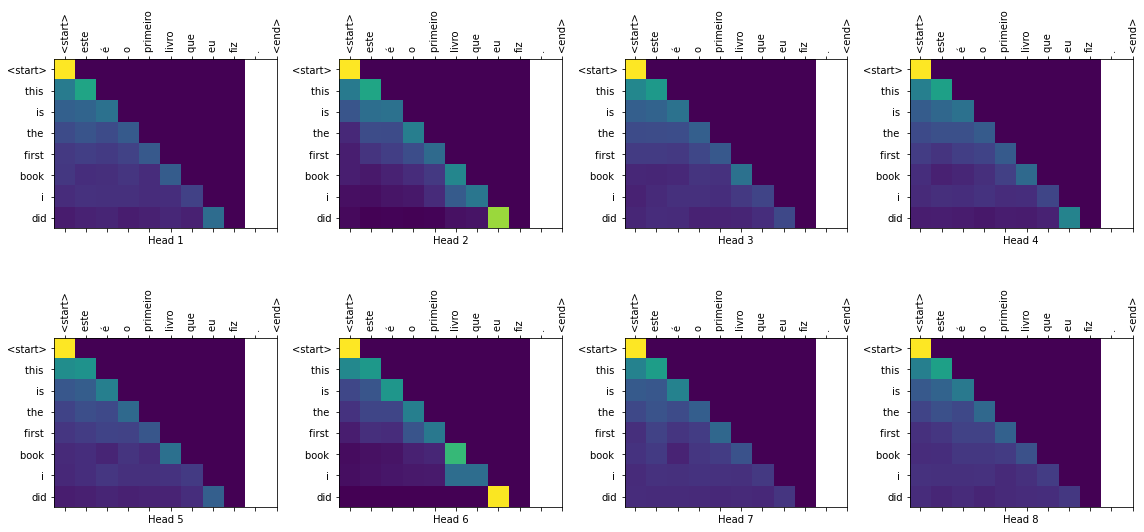

Real translation: this is the first book i've ever done.


In [42]:
translate("este é o primeiro livro que eu fiz.", layer_name='decoder_layer1_attention1')
print("Real translation: this is the first book i've ever done.")

tf.Tensor([8087   16   13    3  124  774 7936    8   74  276  106  330  415    2], shape=(14,), dtype=int32)
Input: este é o primeiro livro que eu já li
Predicted translation: this is the first book i 've ever been talking about .


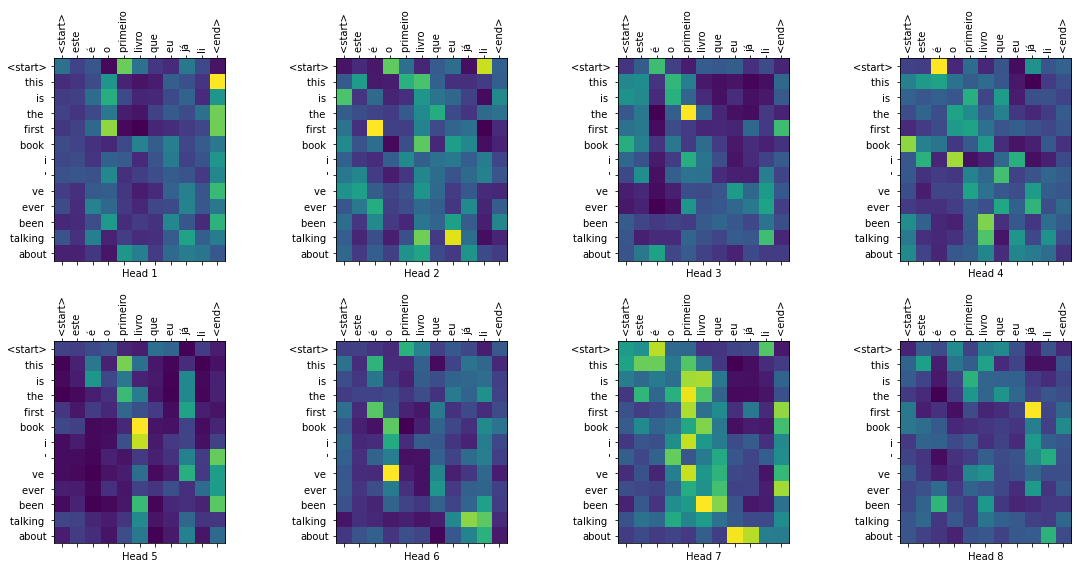

In [43]:
translate('este é o primeiro livro que eu já li',layer_name='decoder_layer1_attention2')